In [56]:
# CONDA: tnt
import numpy as np
import pandas as pd
import seaborn as sns
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:.2f}'.format
import neurokit2 as nk
import matplotlib.pyplot as plt
import os, re
from importlib import reload
import empatica_helpers as eh
import helpers as h
import resampy

# eh.move_folders_to_root('input/empatica/')
# eh.rename_folders('input/empatica/')

dir_list = h.get_dir_list('input/empatica/')

In [69]:
reload(h), reload(eh)

df = pd.DataFrame() 
trimmings_array = np.array([]) # Trimmings are the numbers of samples removed from dataframes coming from a single folder due to differing start or end times. 

for folder in dir_list:
    temp, trimmings = eh.load_data_and_combine(f'input/empatica/{folder}', verbose = False)
    # Concat to df if not empty
    if temp.empty:
        print(f"Skipping {folder} due to empty dataframe.")
        continue
    trimmings_array = np.append(trimmings_array, trimmings)
    df = pd.concat([df, temp])

# df.to_csv('output/empatica_combined_raw2.csv', index=False)

Text(0.5, 0, 'Number of trimmed samples per data file')

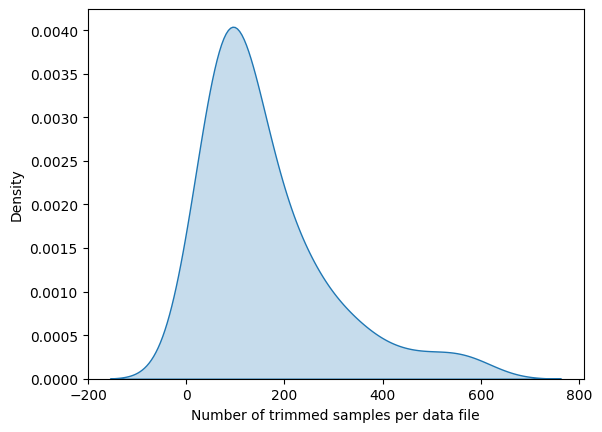

In [70]:
# Seaborn kernel density plot
sns.kdeplot(data=trimmings_array, fill=True)
plt.xlabel("Number of trimmed samples per data file")

# Experimenting with preprocessing

## BVP

In [3]:
dir_list = h.get_dir_list('input/empatica/')
folder = dir_list[4]

file_names = ['ACC.csv', 'HR.csv', 'TEMP.csv', 'EDA.csv', 'BVP.csv']

file_path = os.path.join('input/empatica', folder, file_names[-1])
data = pd.read_csv(file_path, header=None)

starting_time = data.iloc[0, 0]
sampling_rate = int(data.iloc[1, 0])
ppg = data.iloc[2:, :].values

print(f'Starting time: {starting_time}')
print(f'Sampling rate: {sampling_rate}')
print(f'Signal shape: {ppg.shape}, type: {type(ppg)}')

Starting time: 1681301578.0
Sampling rate: 64
Signal shape: (273130, 1), type: <class 'numpy.ndarray'>


In [12]:
# Clean PPG
ppg_clean = nk.ppg_clean(ppg, sampling_rate) # Elgendi, M., Norton, I., Brearley, M., Abbott, D., & Schuurmans, D. (2013). Systolic peak detection in acceleration photoplethysmograms measured from emergency responders in tropical conditions. PloS one, 8(10), e76585.

# Find peaks
info = nk.ppg_findpeaks(ppg_clean, sampling_rate, show=False)
ppg_peaks = info['PPG_Peaks']

# Correct erroneous peak placements
artifacts, ppg_peaks_corrected = nk.signal_fixpeaks(ppg_clean, sampling_rate, iterative=True, show=False, method="Kubios") # Lipponen, J. A., & Tarvainen, M. P. (2019)

# Calculate HR
hr = nk.signal_rate(ppg_peaks_corrected, sampling_rate, desired_length=len(ppg_peaks_corrected)) 

# Calculate HRV indices
# hrv_time = nk.hrv_time(ppg_peaks_corrected, sampling_rate)
# hrv_frequency = nk.hrv_frequency(ppg_peaks_corrected, sampling_rate)
# hrv_rqa = nk.hrv_rqa(ppg_peaks_corrected, sampling_rate)
# hrv_rsa = nk.hrv_rsa(ppg_peaks_corrected, sampling_rate)

/Users/koenraijer/Documents/00 Werk en studie/Msc Data Science & Society/Thesis/.conda/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
/Users/koenraijer/Documents/00 Werk en studie/Msc Data Science & Society/Thesis/.conda/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/Users/koenraijer/Documents/00 Werk en studie/Msc Data Science & Society/Thesis/.conda/lib/python3.11/site-packages/neurokit2/signal/signal_interpolate.py:116: NeuroKitWarning: Duplicate x values detected. Averaging their corresponding y values.
  warn(


In [24]:
# Windowing: https://pandas.pydata.org/pandas-docs/stable/user_guide/window.html#rolling-window
# https://machinelearningtutorials.org/pandas-window-functions-a-comprehensive-guide-with-examples/

# hr to Series
hr_series = pd.Series(hr, name='HR')

# Rolling window
time_window = 10 # seconds
hr_series_rolling_object = hr_series.rolling(window=sampling_rate*time_window)
hr_rolling_mean = hr_series_rolling_object.mean()

hr_series.max()

47358720.0